    - Isabel Rivadero (isarivadero@hotmail.com)
    - Nahuel Almeira (nahu1990@gmail.com)
    - Miguel Vargas (lvc0107@protonmail.com)


# Laboratorio 1: Conceptos básicos de aprendizaje automático

En este laboratorio les tocará probar con distintos parámetros de los algoritmos de aprendizaje automático aprendidos hasta ahora. La idea es que vean como la selección de atributos, el cambio de hiperparámetros, y los distintos algoritmos afectan los resultados de un regresor o clasificador sobre un conjunto de datos.

In [56]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic

%matplotlib inline

## Regresión

### Carga de datos

In [2]:
boston_data = load_boston()
len(boston_data['data'])

506

Como el dataset de boston tiene 506 muestras, generamos 506 indices aleatoriamente
para luego obtener dos subsets de 80% y 20% del dataset desordenados

In [3]:
np.random.permutation(506)

array([ 64, 100, 400, 485, 454, 288, 112, 478,  66, 187, 474,  71, 205,
       133, 247, 333, 444, 207, 393, 398, 200, 352, 363,   7,  92,  59,
       358, 213, 349, 124,  11,  27, 131, 441, 329, 409, 265, 319, 387,
       417, 404,  29, 280, 307, 421, 301, 351, 268,  22, 285, 362, 304,
       160,  73, 369,  57, 405, 341, 353, 480,  40, 448, 111, 192, 403,
        67, 264, 310, 166, 224, 156, 321, 477, 218,  70, 395, 225, 355,
       123, 138, 226, 262,  74, 129, 181, 406, 296, 252,  13,  44,  25,
       491,  91, 496, 149, 228, 424, 350, 191, 239, 109, 219, 221, 375,
       450, 163, 402, 378,   0, 315, 437, 194, 486, 342, 148,  51, 189,
       347, 141,  97,  78, 391,  21,  55, 104, 253,  43, 255, 115, 230,
       122, 169, 427, 386, 366, 373,  24, 306, 411, 263, 118, 443, 305,
       492, 300, 234,  90, 314, 287, 384, 108, 338,  99, 102, 416, 266,
       101, 501, 426,  33, 140, 198,  54, 447, 432,  36, 298,  37, 215,
       323, 299, 494, 493, 408, 308, 388, 418, 214, 270, 498, 11

In [4]:
# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

# Necesario para poder hacer un regresor por feature
feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}
feature_map


{'CRIM': 0,
 'ZN': 1,
 'INDUS': 2,
 'CHAS': 3,
 'NOX': 4,
 'RM': 5,
 'AGE': 6,
 'DIS': 7,
 'RAD': 8,
 'TAX': 9,
 'PTRATIO': 10,
 'B': 11,
 'LSTAT': 12}

In [5]:
print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Regresión sin regularización

Para revisar cómo afecta el cambio de parámetros y los distintos tipos de regresores y atributos (características) al resultado final del algoritmo de aprendizaje automático, lo que se va a hacer es entrenar el regresor tomando sólo un atributo y visualizar eso.

Se busca entrenar utilizando el conjunto de entrenamiento (el terminado en `train`) y evaluar utilizando el conjunto de validación (el terminado en `val`). Luego se visualiza la función calculada para cada conjunto y se la compara.

Los atributos posibles están listados en la descripción del conjunto de datos en la celda anterior. No todos son útiles para visualizar, en particular solo nos interesan los atributos numéricos y descartamos los atributos que se listan a continuación:

- `CHAS`: Atributo categórico (toma valor 0 o 1).
- `RAD`: Atributo categórico (índice).
- `MEDV`: Este valor se lo lista como atributo en la descripción del conjunto de datos pero en realidad es el valor de `y`, i.e. es el valor que tratamos de aproximar con el algoritmo de aprendizaje automático.

In [6]:
# Seleccionamos un atributo de los listados en la descripción que no sea categórico
selected_feature = 'AGE' 

In [7]:
numeric_features = ['AGE', 'CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [8]:
feature_col = feature_map[selected_feature]
feature_col

6

In [9]:
X_train[:, feature_col]# Vemos primeros datos de AGE para entrenamiento

array([ 29.1,  96.6,  97.4,  67. , 100. ,  30.8,  89. ,  78.1, 100. ,
        45.4,  22.3,  97.2,  79.7,  65.2,  96.7,  58.8,  31.3,  21.8,
        37.8,  91.9,  84.7,  15.8, 100. ,  62.5,  97.9,  45.6,  89.1,
        28.1,  58.5,  38.3,  73.1,  30.2,  98.8, 100. ,   6. ,  40.3,
        66.2, 100. ,  53.2,  31.9,  36.8,  96.4, 100. , 100. ,  33.1,
        87.3, 100. ,  97.3,  95.8,  98.9,  70.6,  29.7,  49.3,  88. ,
         8.4,  68.2,  65.1,  93. ,  94.7,  54.2,  84.2,  86.3,  63.1,
        92.6,  52.3,  87.9,  17.5,  68.7,  81.3,  97.1,  53.7,   9.8,
        92.9,  33.5,  97.3,  81.8,  90.8,  93.6, 100. ,  92.4,  49.9,
        54.4,  31.5,  98.8,  74.9,  88.5, 100. ,  44.4,  92.6,  15.7,
        21.9,  65.4,  15.3,  85.7,  92.7,  19.1,  32.2,  52.8,  80.3,
        92.9,  34.2,  85.1,  79.9,  97. , 100. ,  53.8, 100. ,  27.6,
       100. , 100. ,  89.5,  88.8,  98.9,  89.2,  95. ,  82.6,  97.4,
       100. ,  98.8,  71.7,  58.7,  86.9,  71.9,  76.5,  94. ,  33.8,
        91.2, 100. ,

In [10]:
X_train_feature = X_train[:, feature_col].reshape(-1, 1)  # Hay que ser que sea una matriz no un vector para que funcione con scikit learn
type(X_train_feature)

numpy.ndarray

In [11]:
X_train_feature.shape 
# reshape(-1, 1) fransforma el vector en una matriz de una columna y (-1) filas.
# -1 significa indeterminado, entonces numpy resuelve que la cantidad de filas es igual al numero de elementos 
# en el vector, en este caso 400.


(400, 1)

In [12]:
X_val_feature = X_val[:, feature_col].reshape(-1, 1)


### Regresión lineal

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [13]:
# Entrenamos un clasificador utilizando sólo ese atributo sobre el conjunto de entrenamiento (X_train, y_train)
model = LinearRegression()
model.fit(X_train_feature, y_train)

# Evaluamos el desempeño del clasificador utilizando la media del error cuadrado (MSE o mean squared error)
# sobre el conjunto de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# Mientras más cercano a cero mejor
print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model.predict(X_train_feature)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model.predict(X_val_feature)))

Media del error cuadrado para entrenamiento: 73.47
Media del error cuadrado para validación: 68.56


##### Visualización de la regresión lineal

In [14]:
def plot_lineal_regression(X_train_feature, y_train, X_val_feature, y_val, selected_feature):
     
    plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])
    X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Entrenamiento para feature {selected_feature}")

    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Validación para feature {selected_feature}")

    plt.show()

    mean_squared_training_error = mean_squared_error(y_train, model.predict(X_train_feature))
    print(f'Media del error cuadrado para entrenamiento del feature {selected_feature} : {mean_squared_training_error:.2f}')
    
    mean_squared_val_error = mean_squared_error(y_val, model.predict(X_val_feature))
    print(f'Media del error cuadrado para validación del feature {selected_feature}    : {mean_squared_val_error:.2f}')
    


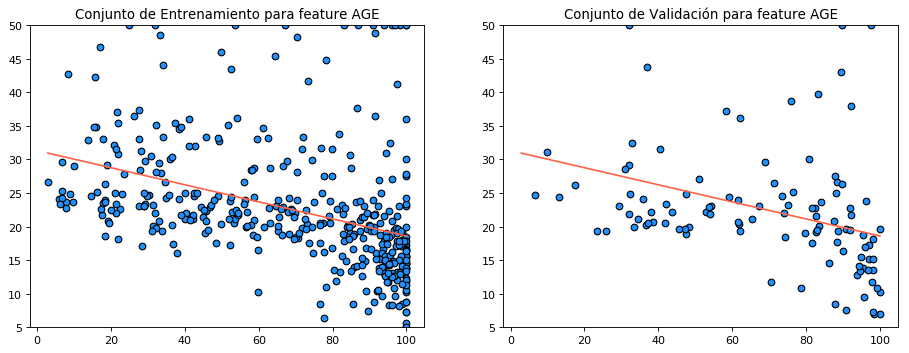

Media del error cuadrado para entrenamiento del feature AGE : 73.47
Media del error cuadrado para validación del feature AGE    : 68.56


In [15]:
plot_lineal_regression(X_train_feature, y_train, X_val_feature, y_val, selected_feature)

El scatter plot  muestra que el feature **AGE** tiene datos demasiado dispersos y que en principio no se ajusta bien con un polinomio de grado 1 (recta). No parece que se puedan ajustar bien tampoco con una regression polinomial.
Analizamos el resto de los features:

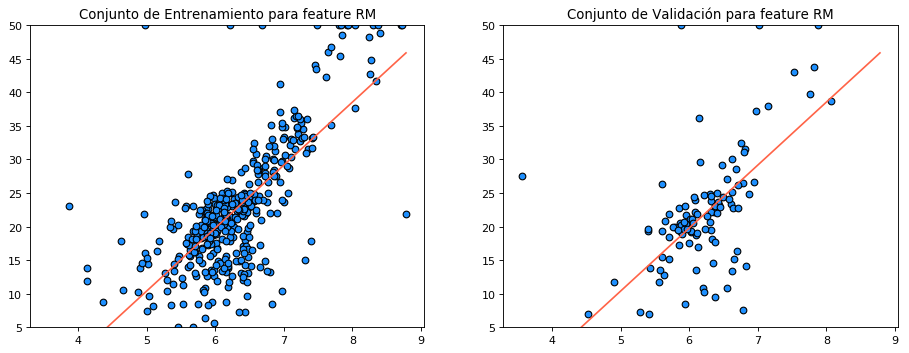

Media del error cuadrado para entrenamiento del feature RM : 41.17
Media del error cuadrado para validación del feature RM    : 53.02


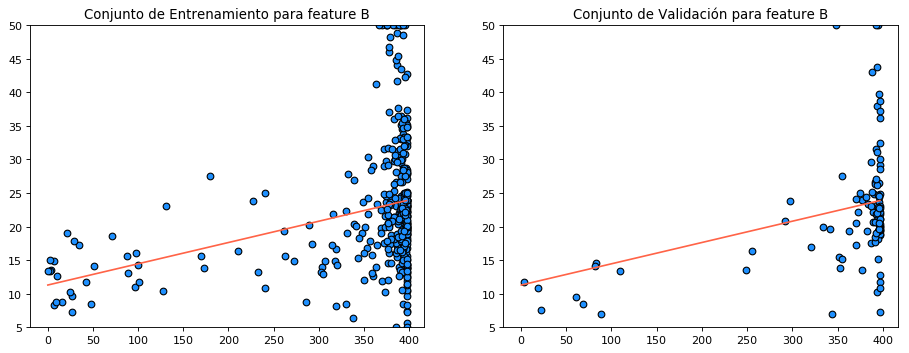

Media del error cuadrado para entrenamiento del feature B : 78.60
Media del error cuadrado para validación del feature B    : 61.73


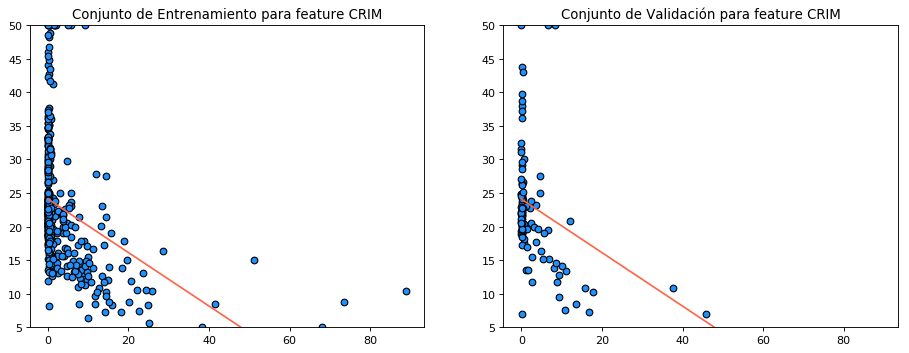

Media del error cuadrado para entrenamiento del feature CRIM : 73.88
Media del error cuadrado para validación del feature CRIM    : 63.58


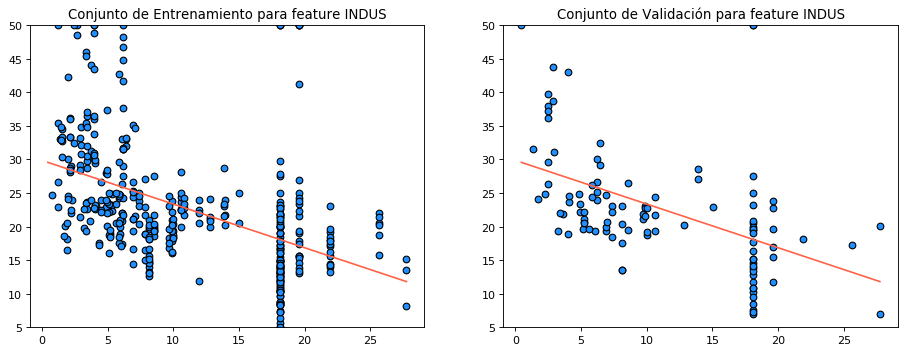

Media del error cuadrado para entrenamiento del feature INDUS : 66.81
Media del error cuadrado para validación del feature INDUS    : 56.63


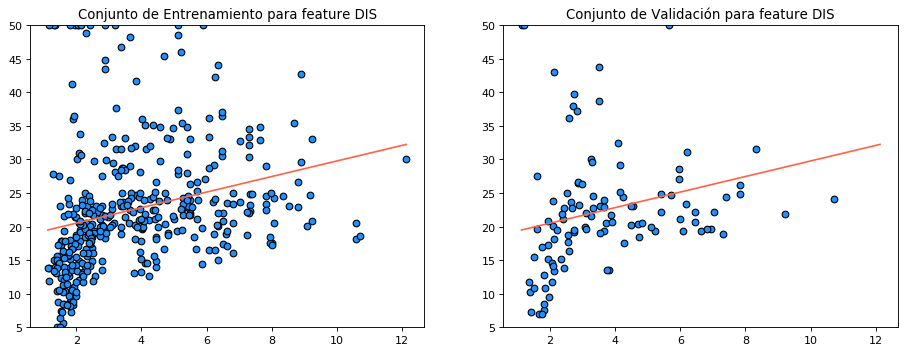

Media del error cuadrado para entrenamiento del feature DIS : 80.67
Media del error cuadrado para validación del feature DIS    : 73.50


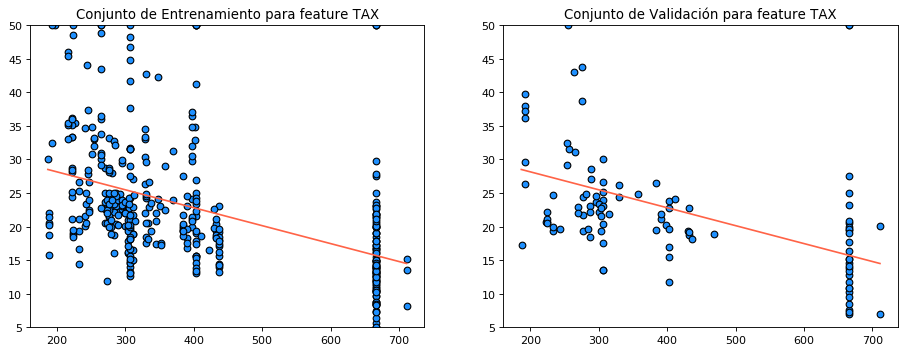

Media del error cuadrado para entrenamiento del feature TAX : 67.09
Media del error cuadrado para validación del feature TAX    : 61.54


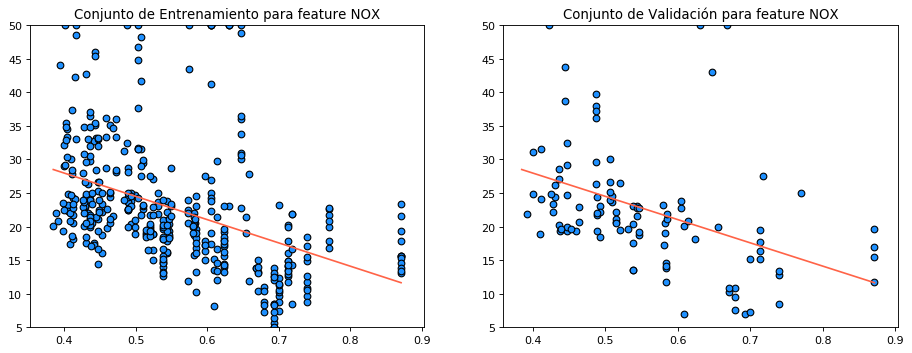

Media del error cuadrado para entrenamiento del feature NOX : 70.54
Media del error cuadrado para validación del feature NOX    : 63.28


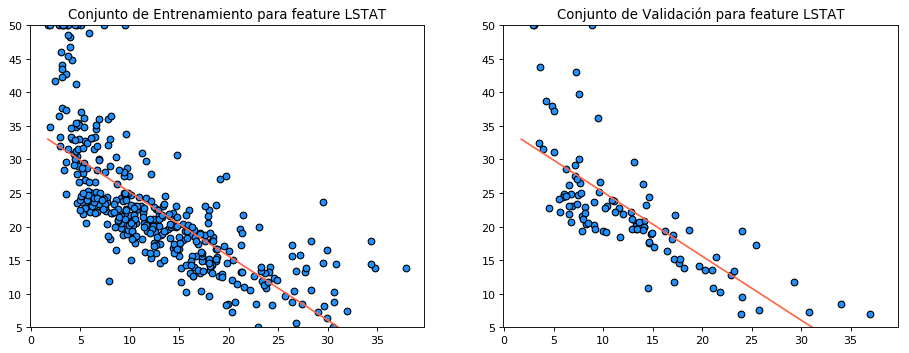

Media del error cuadrado para entrenamiento del feature LSTAT : 39.77
Media del error cuadrado para validación del feature LSTAT    : 33.66


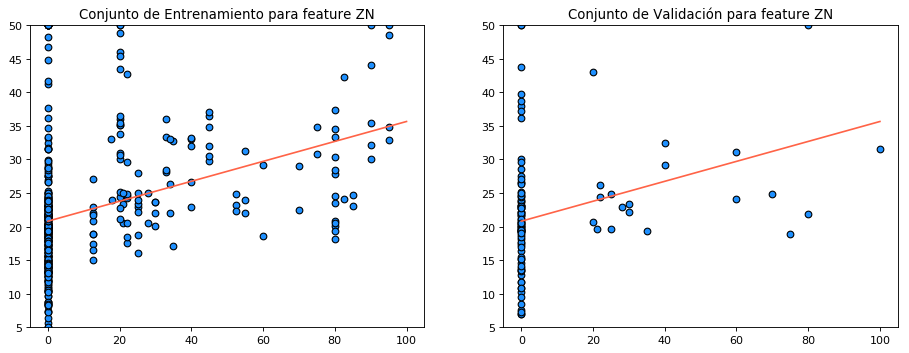

Media del error cuadrado para entrenamiento del feature ZN : 74.13
Media del error cuadrado para validación del feature ZN    : 71.00


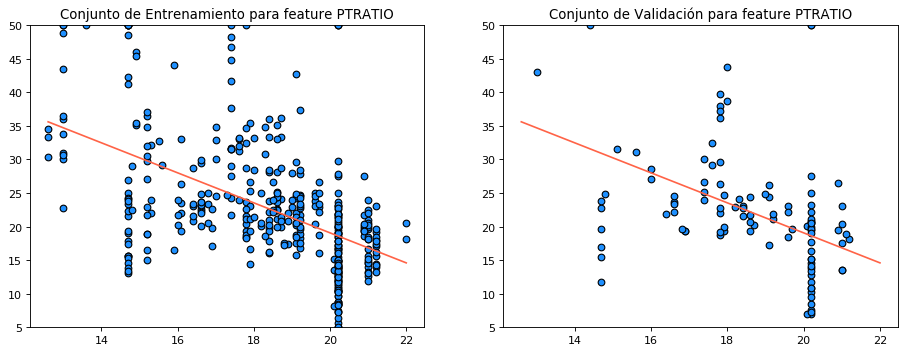

Media del error cuadrado para entrenamiento del feature PTRATIO : 62.06
Media del error cuadrado para validación del feature PTRATIO    : 65.02


In [16]:
for selected_feature in set(numeric_features) - {'AGE'}:
    feature_col = feature_map[selected_feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)  # Hay que ser que sea una matriz no un vector para que funcione con scikit learn
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(X_train_feature, y_train)

    plot_lineal_regression(X_train_feature, y_train, X_val_feature, y_val, selected_feature)

### Regresión polinomial

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Analizamos el feature **LSTAT**

In [17]:
selected_feature = 'LSTAT'

In [18]:
for polynomial_degree in range(15):

    # Probamos distintos grados del polinomio

    poly_features = PolynomialFeatures(polynomial_degree)
    poly_features.fit(X_train_feature)
    X_poly_train = poly_features.transform(X_train_feature)
    X_poly_val = poly_features.transform(X_val_feature)

    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    print('='*100)

    mean_squared_training_error = mean_squared_error(y_train, model.predict(X_poly_train))
    print(f'Media del error cuadrado para entrenamiento del feature {selected_feature} con grado {polynomial_degree}: {mean_squared_training_error:.2f}')
    
    mean_squared_val_error = mean_squared_error(y_val, model.predict(X_poly_val))
    print(f'Media del error cuadrado para validación del feature {selected_feature} con grado {polynomial_degree} : {mean_squared_val_error:.2f}')


Media del error cuadrado para entrenamiento del feature LSTAT con grado 0: 86.81
Media del error cuadrado para validación del feature LSTAT con grado 0 : 75.41
Media del error cuadrado para entrenamiento del feature LSTAT con grado 1: 62.06
Media del error cuadrado para validación del feature LSTAT con grado 1 : 65.02
Media del error cuadrado para entrenamiento del feature LSTAT con grado 2: 61.77
Media del error cuadrado para validación del feature LSTAT con grado 2 : 64.66
Media del error cuadrado para entrenamiento del feature LSTAT con grado 3: 61.48
Media del error cuadrado para validación del feature LSTAT con grado 3 : 63.71
Media del error cuadrado para entrenamiento del feature LSTAT con grado 4: 59.01
Media del error cuadrado para validación del feature LSTAT con grado 4 : 60.68
Media del error cuadrado para entrenamiento del feature LSTAT con grado 5: 58.03
Media del error cuadrado para validación del feature LSTAT con grado 5 : 60.54
Media del error cuadrado para entrenamie

El error cuadrado medio devuelve para un feature respecto de la función de ajuste. Mientras mas cerca de 0 el error es menor.
Para el feature anterior vemos que se obtiene el menor error para grado 10

##### Visualización de la regresión polinomial

In [19]:
for polynomial_degree in range(1, 10):

    # Probamos distintos grados del polinomio

    poly_features = PolynomialFeatures(polynomial_degree)
    poly_features.fit(X_train_feature)
    X_poly_train = poly_features.transform(X_train_feature)
    X_poly_val = poly_features.transform(X_val_feature)

    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    plot_polinomial_regression(X_train_feature, y_train, X_val_feature, y_val, selected_feature, polynomial_degree)


NameError: name 'plot_polinomial_regression' is not defined

### Regresión lineal con regularización

- https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [20]:

for alpha in np.arange(1, 10, 1):
    print('='*100)

    print(f'alpha: {alpha} para feature: {selected_feature}' )
    model = Ridge(alpha=alpha)
    model.fit(X_train_feature, y_train)
    print('Media del error cuadrado para entrenamiento: %.2f' % 
          mean_squared_error(y_train, model.predict(X_train_feature)))
    print('Media del error cuadrado para validación: %.2f' %
          mean_squared_error(y_val, model.predict(X_val_feature)))

alpha: 1 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.02
alpha: 2 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.01
alpha: 3 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.01
alpha: 4 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.01
alpha: 5 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.00
alpha: 6 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 65.00
alpha: 7 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado para validación: 64.99
alpha: 8 para feature: LSTAT
Media del error cuadrado para entrenamiento: 62.06
Media del error cuadrado

##### Visualización de la regresión lineal

In [21]:
def plot_lineal_regression_ridge(X_train_feature, y_train, X_val_feature, y_val, selected_feature, alpha):

    plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])
    X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Entrenamiento para feature {selected_feature} con alpha en ridge {alpha}")


    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Validación para feature {selected_feature} con alpha en ridge {alpha}")
    plt.show()

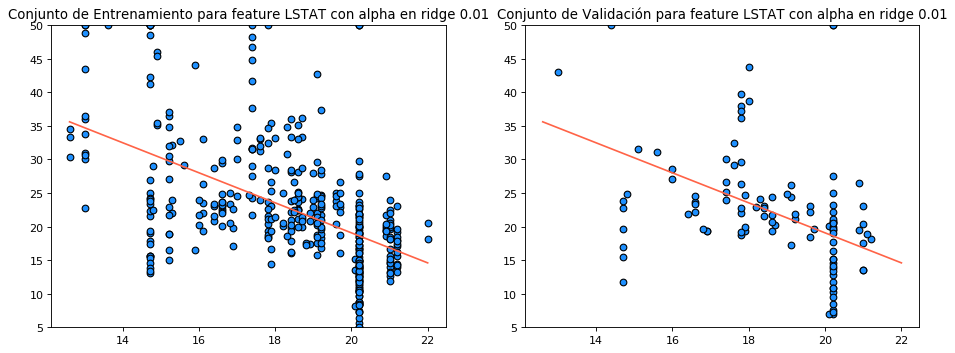

In [22]:
alpha =  0.01 #Parámetro de regularización. También denominado como parámetro `lambda`.
model = Ridge(alpha=alpha)
model.fit(X_train_feature, y_train)

plot_lineal_regression_ridge(X_train_feature, y_train, X_val_feature, y_val, selected_feature, alpha)
 

No tiene sentido mucho sentido aplicar el ridge a un polinomio de grado 1(pues no estamos suavizando nada)
De echo con una recta tenemos un problema de underfitting y el ridge sirve para suavizar polinomios con grados altos, que ajustan muy bien en etapa de entrenamiento pero no en etapa de validación(overfitting)


### Regresión polinomial con regularización

Quisimos suavizar polinomios de grado 5 en adelante , pero obtenemos el siguiente error:**'result may not be accurate.'**
Probamos suavizar un polinomio de  grado 4.

In [23]:
polynomial_degree = 4
alpha = 100

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_feature)
X_poly_train = poly_features.transform(X_train_feature)
X_poly_val = poly_features.transform(X_val_feature)

model = Ridge(alpha=alpha)
model.fit(X_poly_train, y_train)

print('='*100)
mean_squared_training_error = mean_squared_error(y_train, model.predict(X_poly_train))
print(f'Media del error cuadrado para entrenamiento del feature {selected_feature} : {mean_squared_training_error:.2f}')

mean_squared_val_error = mean_squared_error(y_val, model.predict(X_poly_val))
print(f'Media del error cuadrado para validación del feature {selected_feature}    : {mean_squared_val_error:.2f}')


Media del error cuadrado para entrenamiento del feature LSTAT : 61.66
Media del error cuadrado para validación del feature LSTAT    : 64.34


##### Visualización de la regresión polinomial

In [24]:
selected_feature = 'LSTAT'

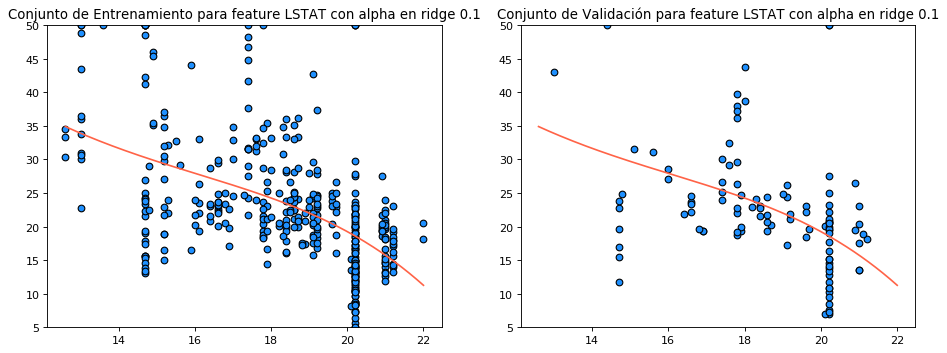

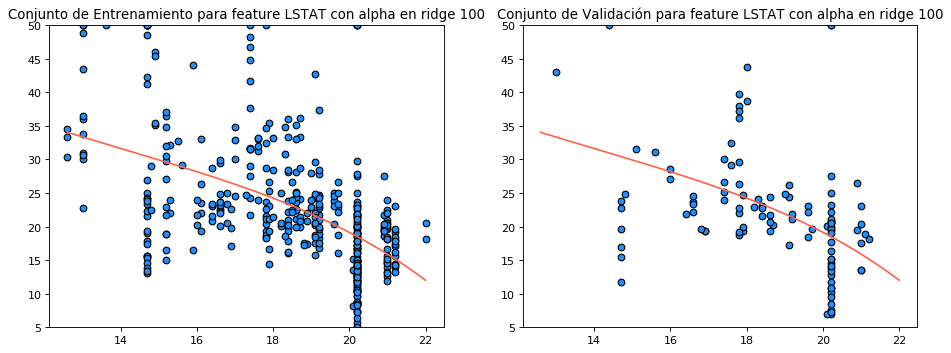

In [25]:
for alpha in (0.1, 100):
    plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

    polynomial_degree = 4
    poly_features = PolynomialFeatures(polynomial_degree)
    poly_features.fit(X_train_feature)
    X_poly_train = poly_features.transform(X_train_feature)
    X_poly_val = poly_features.transform(X_val_feature)

    model = Ridge(alpha=alpha)
    model.fit(X_poly_train, y_train)
    
    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])
    X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
    X_linspace_poly = poly_features.transform(X_linspace)

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Entrenamiento para feature {selected_feature} con alpha en ridge {alpha}")

    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Validación para feature {selected_feature} con alpha en ridge {alpha}")

    plt.show()

Se observa que para un $\alpha$ muy alto(100) en tiempo de validación el polinomio de grado 4 ajusta bien

Analizamos otros features:

In [26]:
def plot_polinomial_regression_ridge(X_train_feature, y_train, X_val_feature, y_val, selected_feature, alpha):
    plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])
    X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
    X_linspace_poly = poly_features.transform(X_linspace)

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Entrenamiento para feature {selected_feature} con alpha en ridge {alpha}")

    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Validación para feature {selected_feature} con alpha en ridge {alpha}")

    plt.show()

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.98737e-47): result may not be accurate.
  overwrite_a=True).T


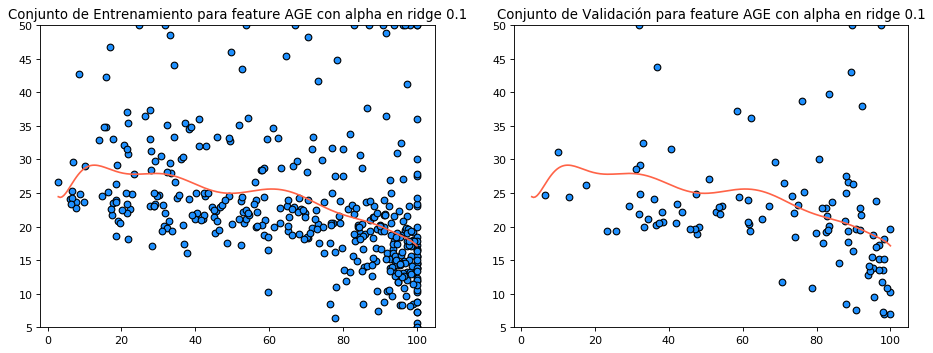

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.75291e-42): result may not be accurate.
  overwrite_a=True).T


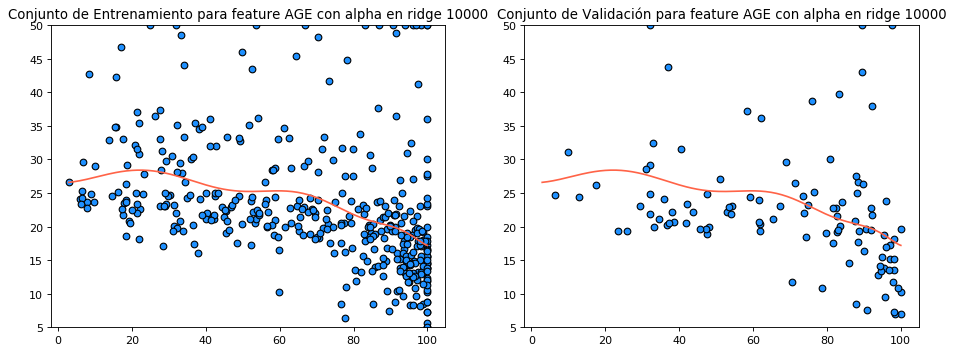

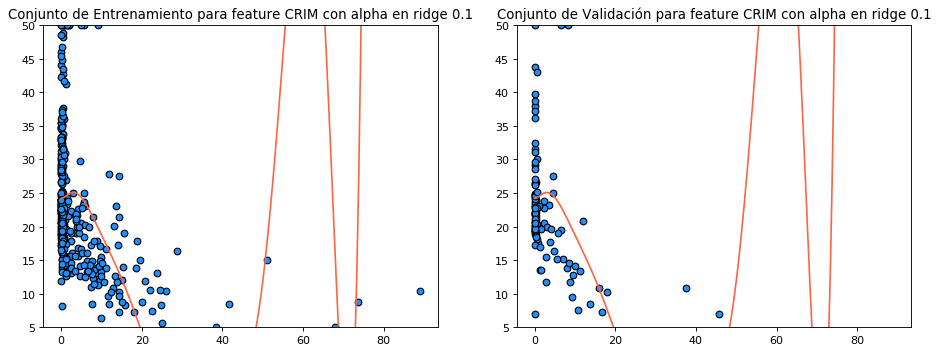

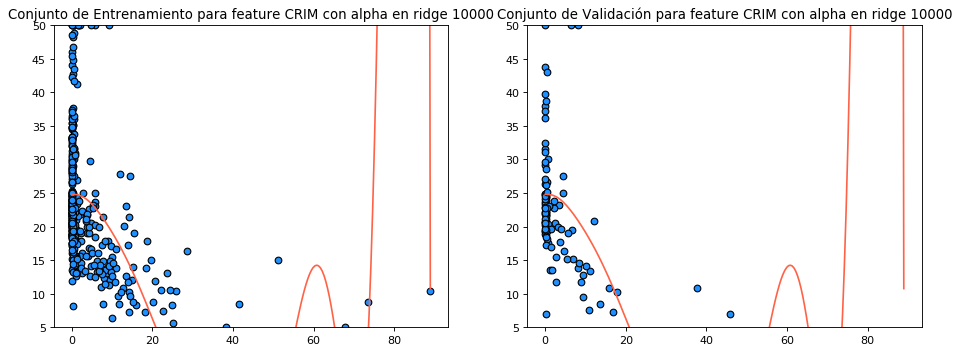

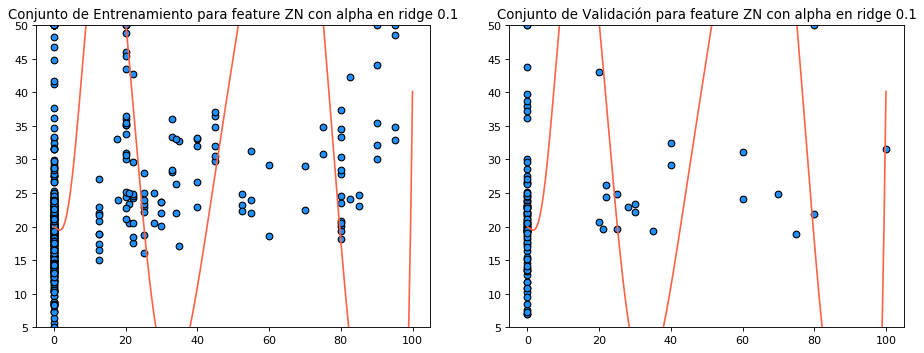

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.38116e-41): result may not be accurate.
  overwrite_a=True).T


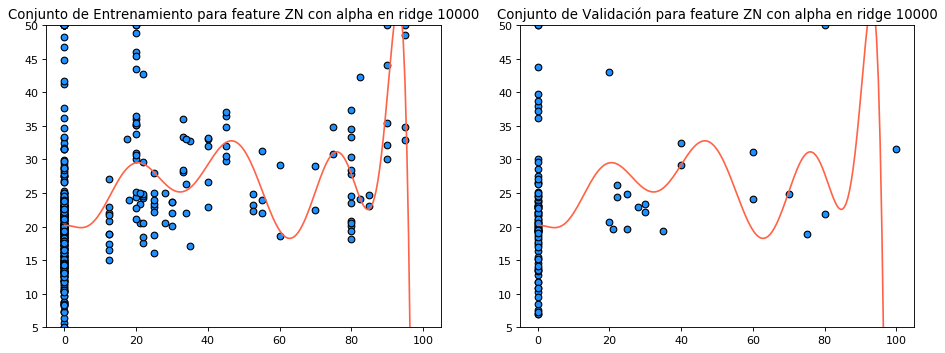

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.77475e-34): result may not be accurate.
  overwrite_a=True).T


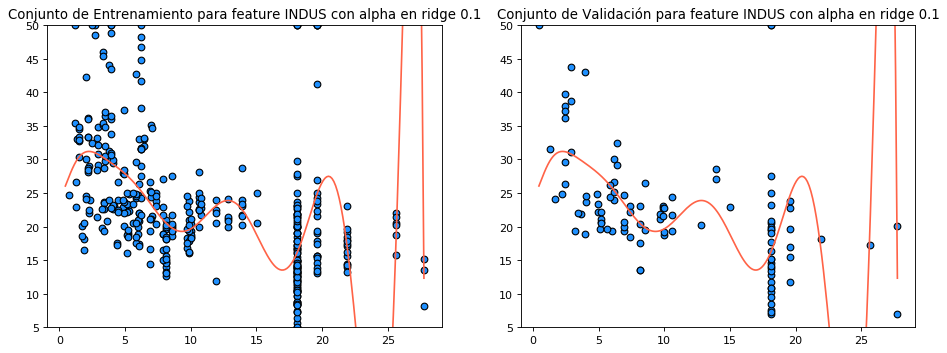

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.33454e-29): result may not be accurate.
  overwrite_a=True).T


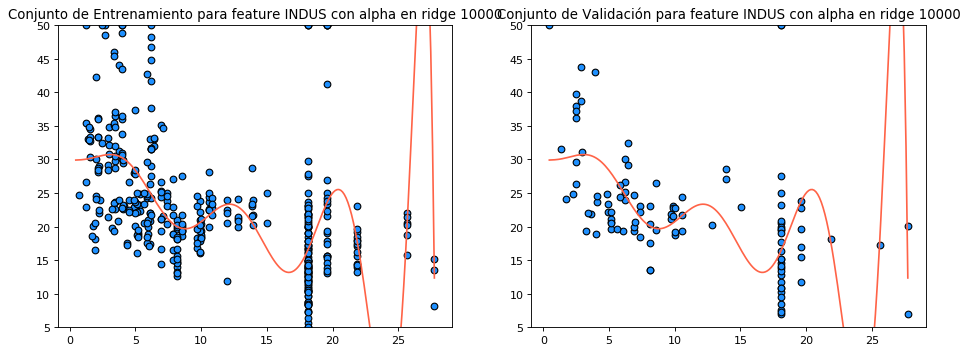

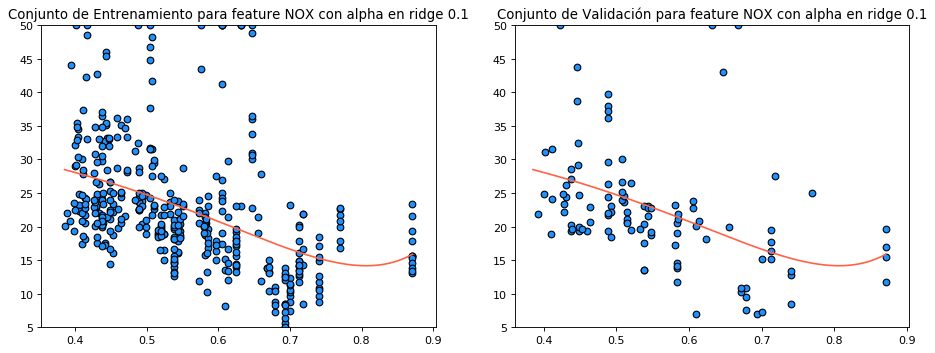

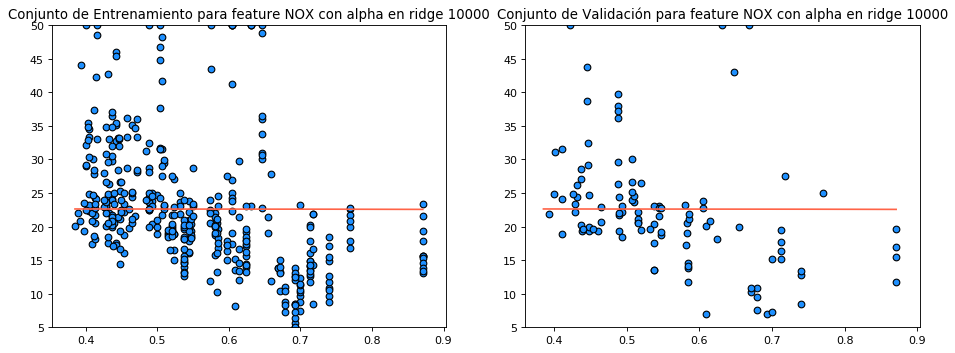

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.05892e-23): result may not be accurate.
  overwrite_a=True).T


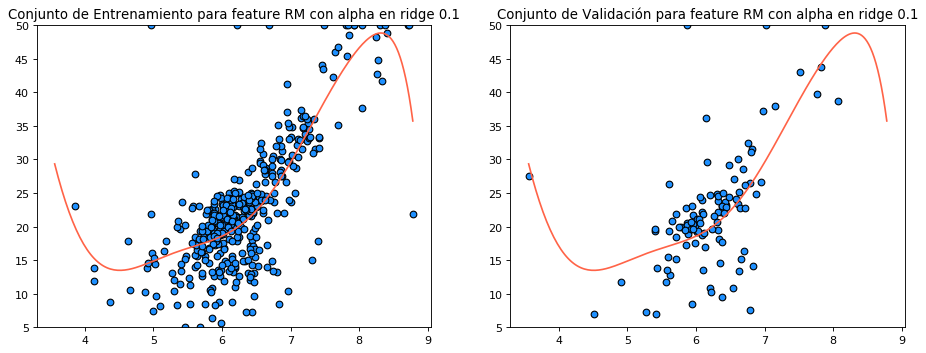

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.86182e-18): result may not be accurate.
  overwrite_a=True).T


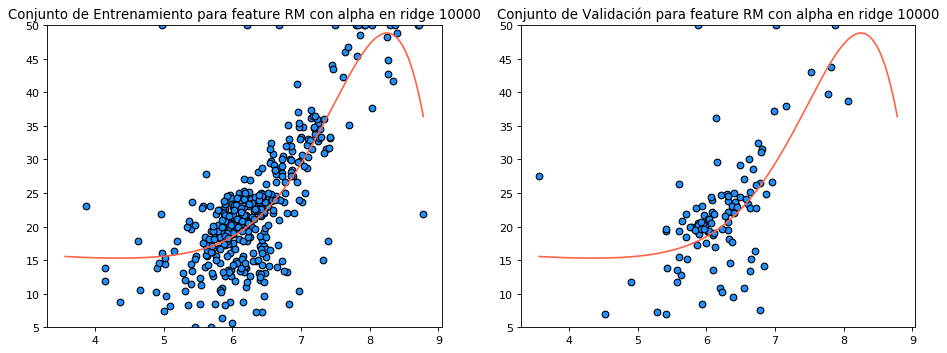

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.15225e-26): result may not be accurate.
  overwrite_a=True).T


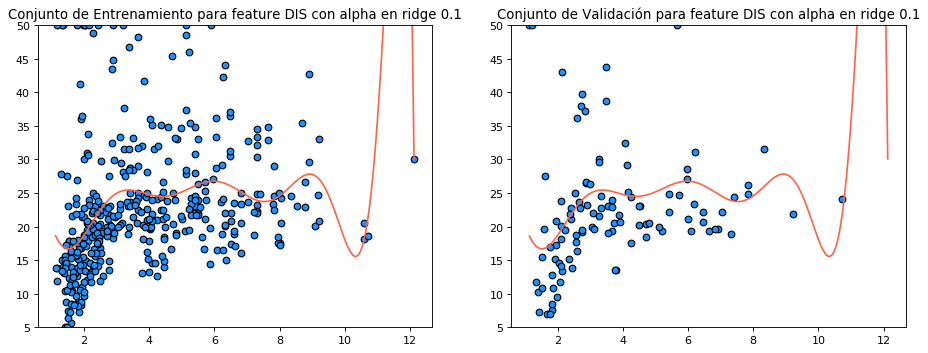

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.27466e-21): result may not be accurate.
  overwrite_a=True).T


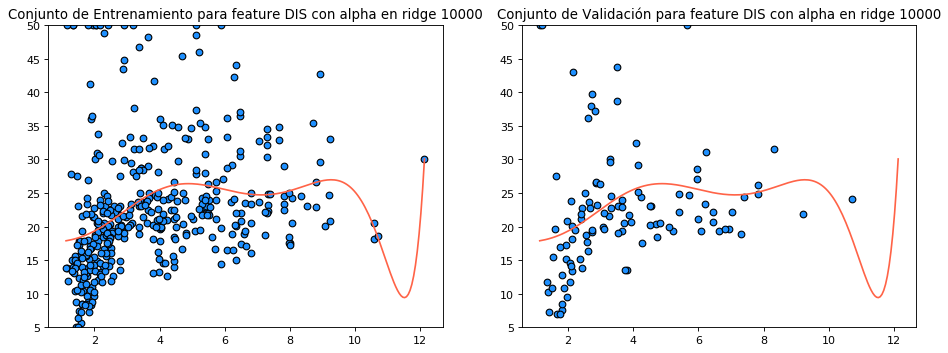

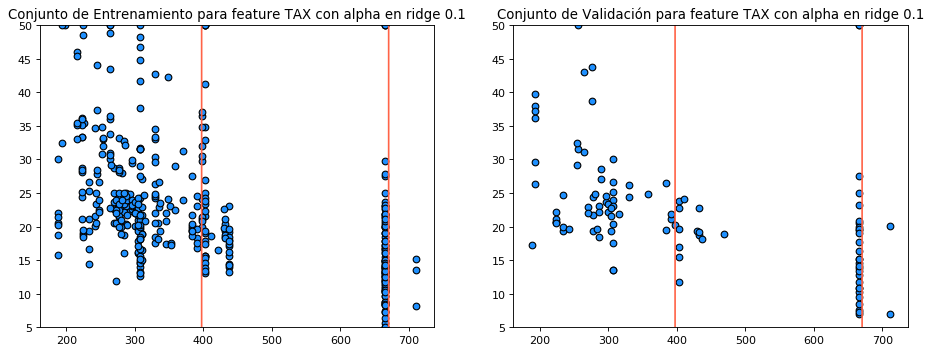

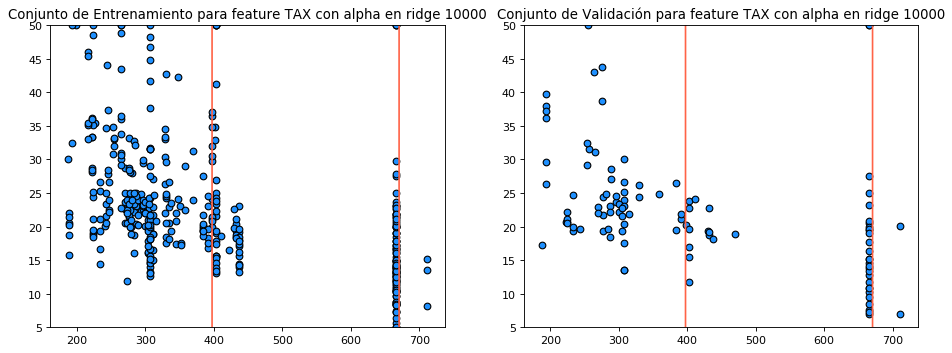

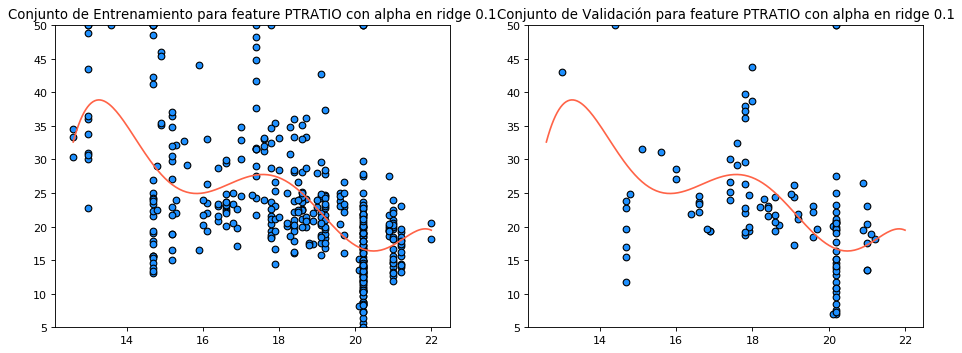

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43661e-27): result may not be accurate.
  overwrite_a=True).T


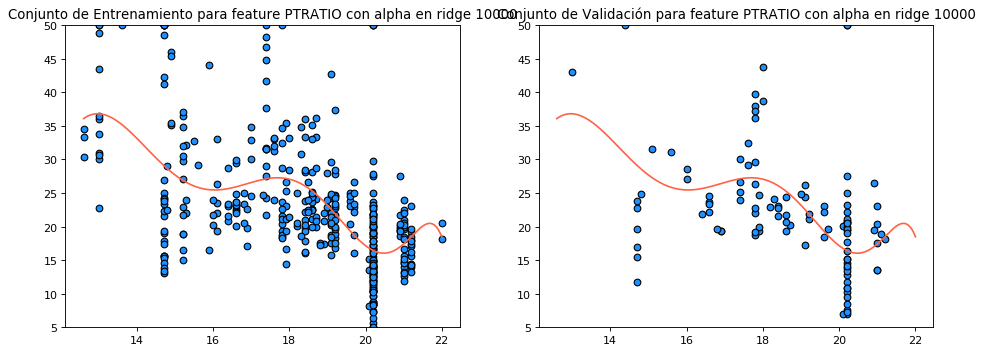

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48842e-60): result may not be accurate.
  overwrite_a=True).T


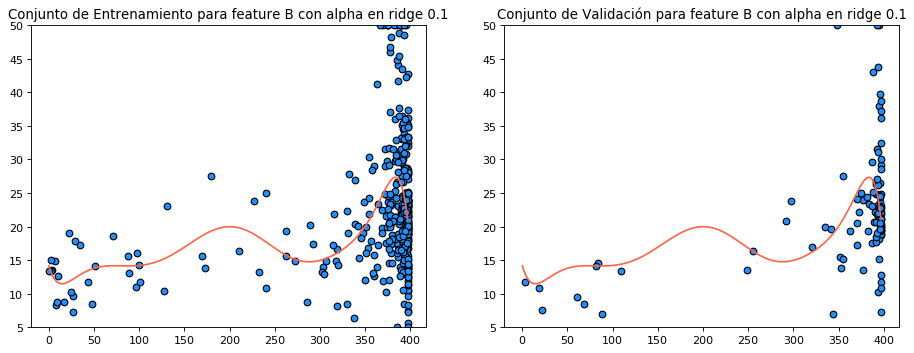

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48842e-55): result may not be accurate.
  overwrite_a=True).T


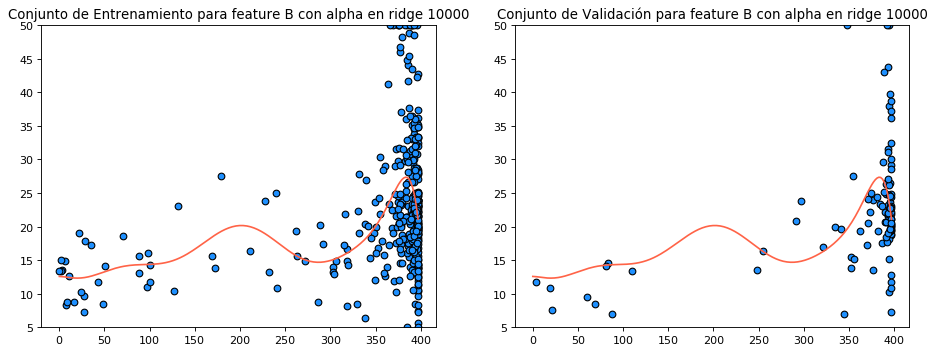

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.94113e-37): result may not be accurate.
  overwrite_a=True).T


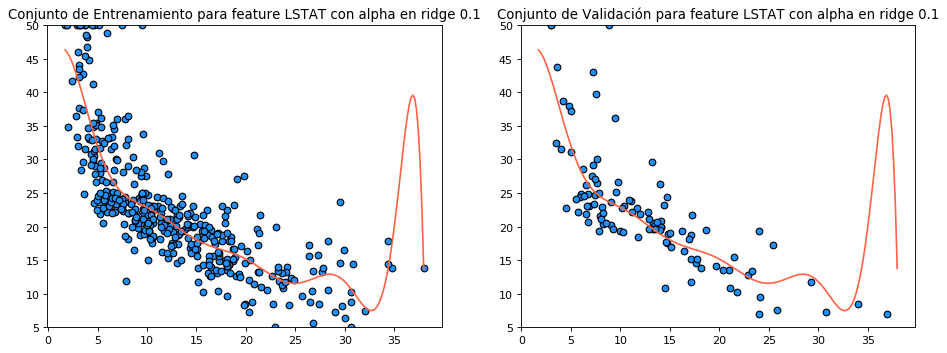

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.74674e-32): result may not be accurate.
  overwrite_a=True).T


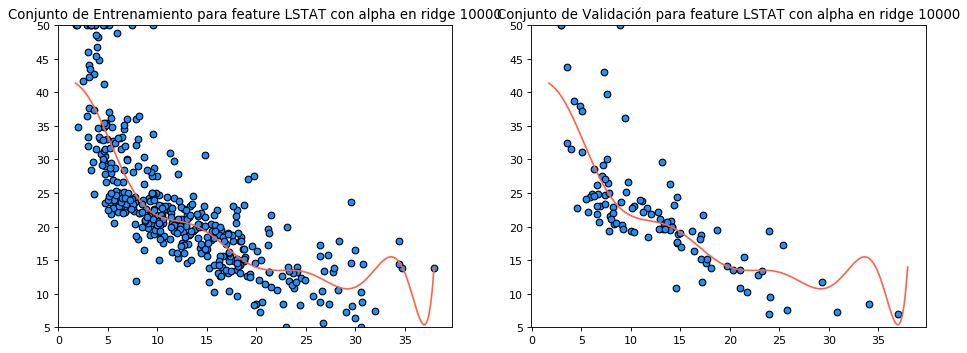

In [27]:
for selected_feature in numeric_features:
    feature_col = feature_map[selected_feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)  # Hay que ser que sea una matriz no un vector para que funcione con scikit learn
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)
    for alpha in (0.1, 10000):
        polynomial_degree = 11
        poly_features = PolynomialFeatures(polynomial_degree)
        poly_features.fit(X_train_feature)
        X_poly_train = poly_features.transform(X_train_feature)
        X_poly_val = poly_features.transform(X_val_feature)

        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train)

        plot_polinomial_regression_ridge(X_train_feature, y_train, X_val_feature, y_val, selected_feature, alpha)
 

Luego de probar con polinomios de grado 11 y terminos de regularización pequeños y grandes, observamos que algunos features pueden ajustarse con un polinomio (por ejemplo RM)  y otros features no se pueden ajustar correctamente ni alterando el ridge o variando el grado del polinomio, dado a que estan muy dispersos.

## Clasificación binaria

La clasificación binaria tiene dos posibles etiquetas para su clasificación: SI y NO (o 0 y 1, o -1 y 1). Nuevamente, se busca entrenar utilizando el conjunto de entrenamiento (el terminado en `train`) y evaluar utilizando el conjunto de validación (el terminado en `val`). Luego se visualiza la función calculada para cada conjunto y se la compara.

Similar al caso anterior, para poder visualizar los distintos atributos y cómo estos afectan el modelo, debemos hacer uso de una selección de atributos a mano. En este caso todos los atributos son válidos, puesto que todos son numéricos. Como tenemos una clasificación, lo que buscamos ver es la frontera de decisión eligiendo distintos atributos y parámetros para distintos clasificadores. En este caso elegimos 2 atributos ya que la clase se representará por color dentro del gráfico.

### Carga de datos

In [28]:
breast_cancer_data = load_breast_cancer()

# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(569)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = breast_cancer_data['data'][shuff_train]
X_val = breast_cancer_data['data'][shuff_val]

y_train = breast_cancer_data['target'][shuff_train]
y_val = breast_cancer_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(breast_cancer_data['feature_names'])}

print(breast_cancer_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [29]:
print("Listado de atributos\n====================")
for feature in breast_cancer_data['feature_names']:
    print("- %s" % feature)

Listado de atributos
- mean radius
- mean texture
- mean perimeter
- mean area
- mean smoothness
- mean compactness
- mean concavity
- mean concave points
- mean symmetry
- mean fractal dimension
- radius error
- texture error
- perimeter error
- area error
- smoothness error
- compactness error
- concavity error
- concave points error
- symmetry error
- fractal dimension error
- worst radius
- worst texture
- worst perimeter
- worst area
- worst smoothness
- worst compactness
- worst concavity
- worst concave points
- worst symmetry
- worst fractal dimension


In [30]:
# Seleccionamos dos atributo de los listados en el apartado anterior, uno para el eje x y otro para el eje y
x_feature = 'mean radius'
y_feature = 'mean texture'

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

### Perceptrón

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

In [31]:
penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = 0.1 # Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 100 # Cantidad máxima de iteraciones del algoritmo

model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
model.fit(X_train_feature, y_train)

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.56
Exactitud para validación: 0.49


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


#### Matriz de confusión

La matriz de confusión sirve en clasificación para ver que tanto se desviaron las instancias (de entrenamiento o de validación) de su valor real.

In [32]:
def _plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature):

    plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

    plt.subplot(2, 2, 1)
    title = f'Entrenamiento (sin normalizar) {x_feature}-{y_feature}'
    plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                          classes=breast_cancer_data.target_names,
                          title=title)
    plt.subplot(2, 2, 3)
    title = f'Entrenamiento (normalizando) {x_feature}-{y_feature}'
    plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                          classes=breast_cancer_data.target_names, normalize=True,
                          title=title)

    plt.subplot(2, 2, 2)
    title = f'Validación (sin normalizar) {x_feature}-{y_feature}'
    plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                          classes=breast_cancer_data.target_names,
                          title=title)
    plt.subplot(2, 2, 4)
    title = f'Validación (normalizando) {x_feature}-{y_feature}'
    plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                          classes=breast_cancer_data.target_names, normalize=True,
                          title=title)

    plt.show()
 

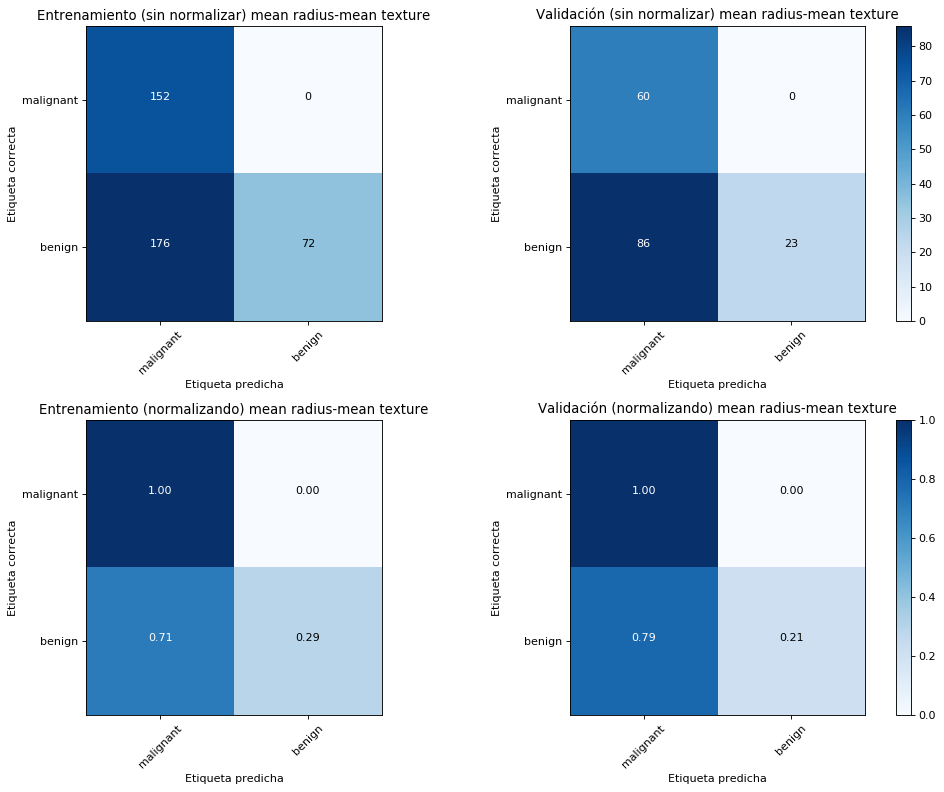

In [33]:
_plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

#### Visualización de la frontera de decisión

In [34]:
def plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature):
    plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

    xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

    cmap_dots = ListedColormap(['tomato', 'dodgerblue'])
    cmap_back = ListedColormap(['lightcoral', 'skyblue'])

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
    plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Conjunto de Entrenamiento {x_feature}-{y_feature}")

    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
    plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Conjunto de Validación {x_feature}-{y_feature}")

    plt.show()


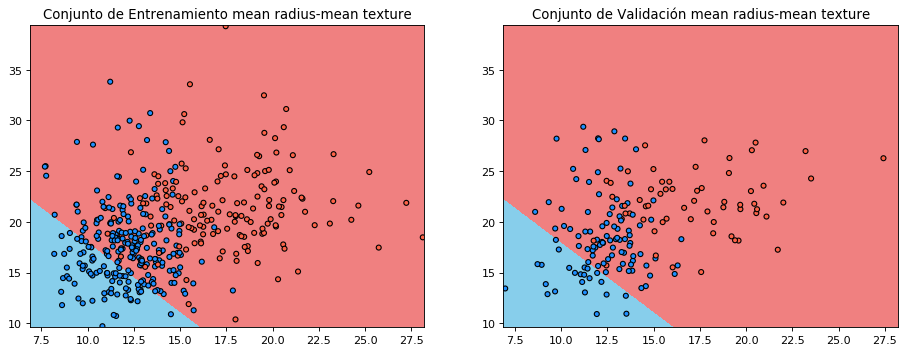

In [35]:
plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

**Probamos Perceptron aumentando la cantidad de iteraciones maximas(pues el algoritmo original itera hasta que no hay datos en el set de entrenamiento mal clasificados)**


In [36]:
penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = 0.1 # Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 1000 # Cantidad máxima de iteraciones del algoritmo
model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.86
Exactitud para validación: 0.85


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


**Se observa que la precicio del ajuste mejora de 0.56 a 0.86 y 0.49 a 0.85 para los set de entrenamiento y validación respectivamente**

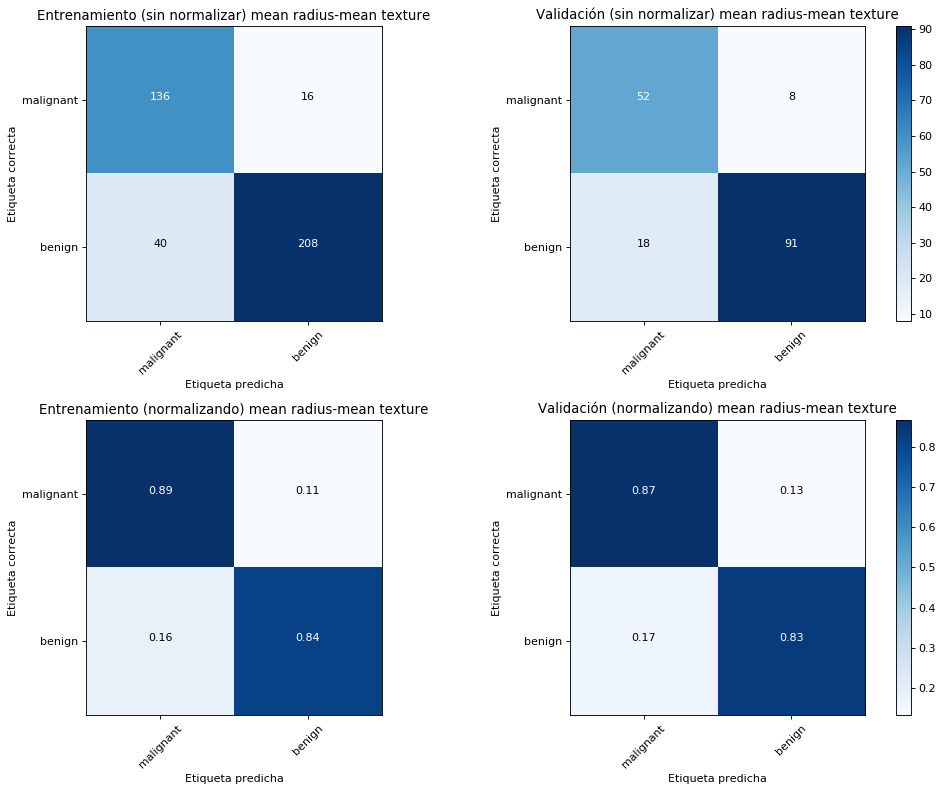

In [37]:
_plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

**Las matrices de confusion muestran menos errores**

#### Visualización de la frontera de decisión

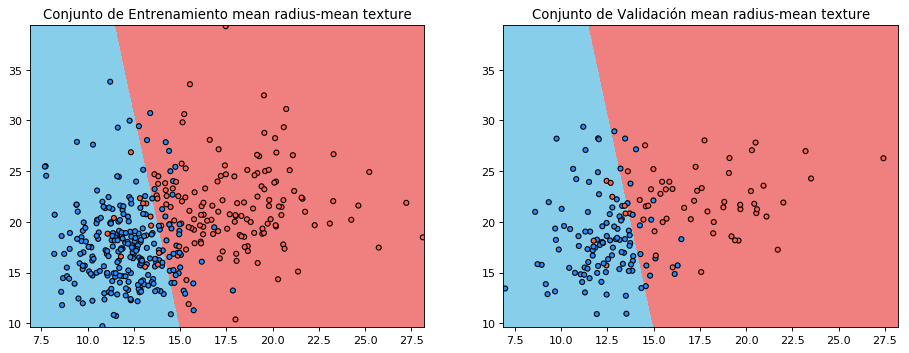

In [38]:
plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

**Las fronteras tambien separan de manera mas clara**


**Tras varias pruebas encontramos que el termino de regularización  $\alpha$ = 0.5 da una mejor precisión**

In [39]:
penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
max_iter = 1000 # Cantidad máxima de iteraciones del algoritmo
model = Perceptron(penalty=penalty, alpha=0.5, max_iter=max_iter)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.89
Exactitud para validación: 0.88


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


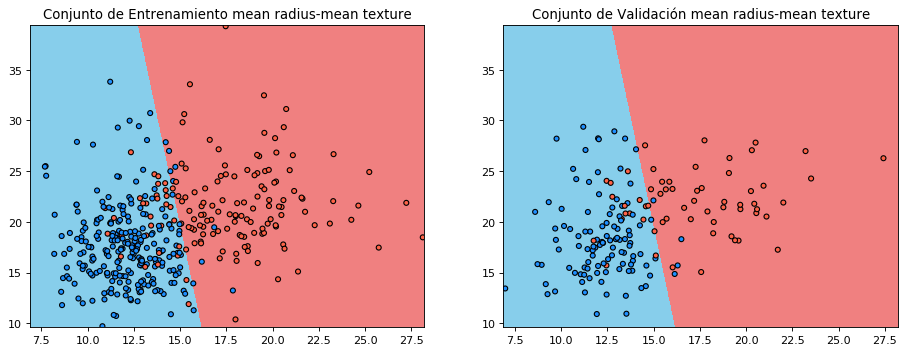

In [40]:
plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

**Por ultimo probamos otros valores para el parametro penalty, pero no se logro mejorar la precición**

In [41]:
penalty = 'l2' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
model = Perceptron(penalty=penalty, alpha=0.5, max_iter=1000)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.62
Exactitud para validación: 0.64


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [42]:
penalty = 'elasticnet' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
model = Perceptron(penalty=penalty, alpha=0.5, max_iter=1000)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.62
Exactitud para validación: 0.64


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


### Regresión logística

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [43]:
penalty =  'l1'# Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha = 0.01 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.90
Exactitud para validación: 0.88


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:
penalty = 'l1'# Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha = 1000 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.38
Exactitud para validación: 0.36


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Un valor de $\alpha$ muy alto genera una baja en la precición**

In [46]:
penalty = 'l2' #l2 (cuadrados).
alpha = 0.001

model = LogisticRegression(penalty=penalty, C=1./alpha)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.90
Exactitud para validación: 0.88


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Cambiar el tipo de penalty no afecta el mejor resultado de precición**

#### Matriz de confusión

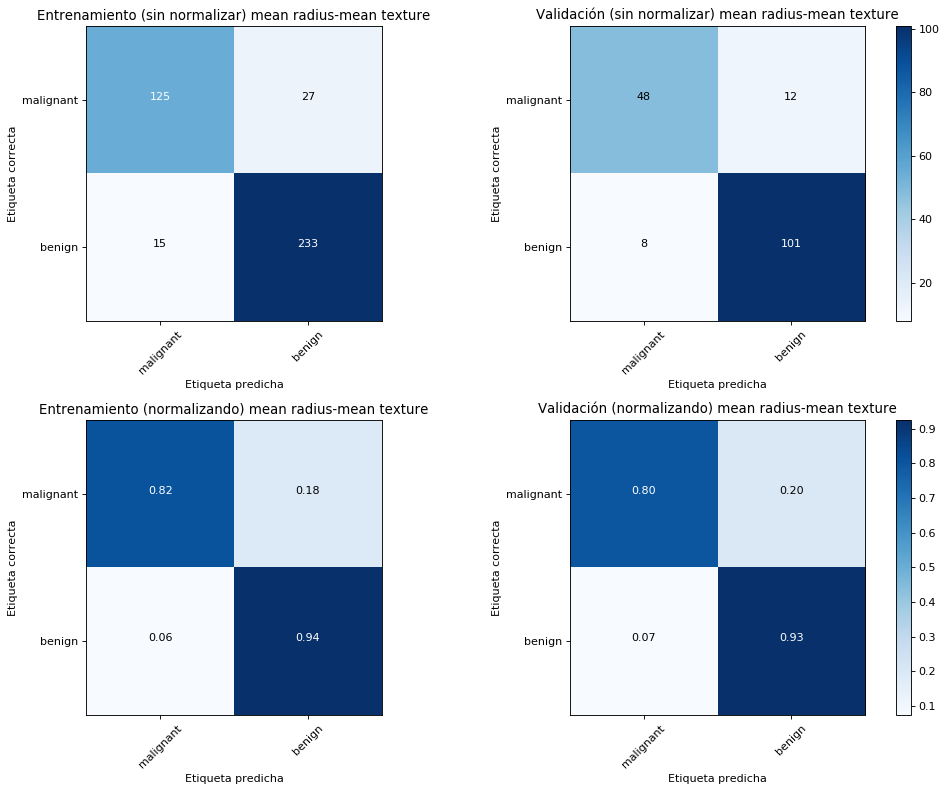

In [47]:
_plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

#### Visualización de la frontera de decisión

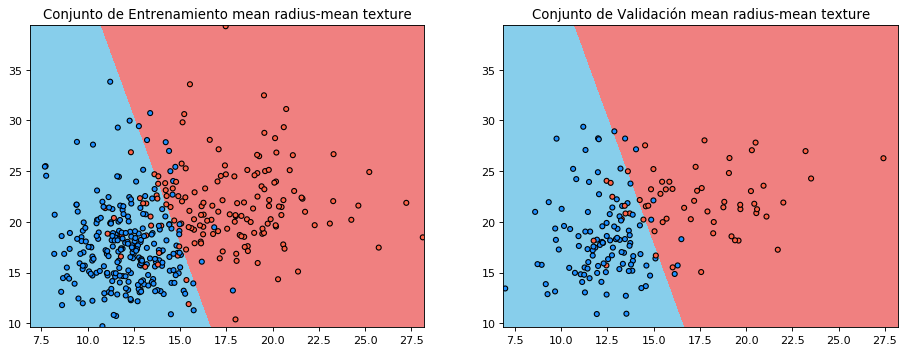

In [48]:
plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

### Vecinos más cercanos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [49]:
n_neighbors = 4    # Cantidad de vecinos a tener en cuenta
metric = 'cosine'  # Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.73
Exactitud para validación: 0.60


In [50]:
n_neighbors = 10   
metric = 'manhattan'

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.90
Exactitud para validación: 0.89


In [51]:
n_neighbors = 15    
metric = 'euclidean'

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.91
Exactitud para validación: 0.91


#### Matriz de confusión

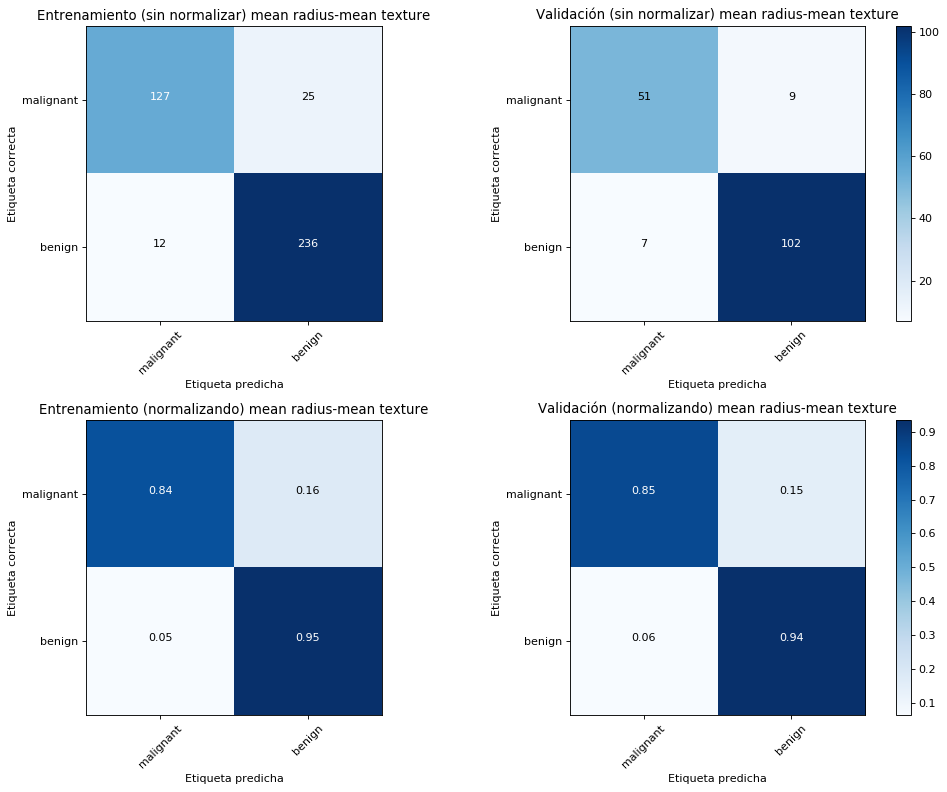

In [52]:
_plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

#### Visualización de la frontera de decisión

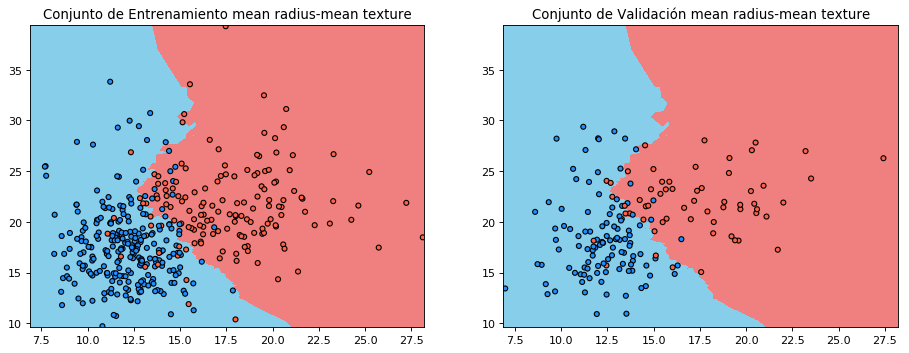

In [53]:
plot_frontera_decision(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

**Probamos con otros features**
- mean perimeter
- mean area

Probamos KNeighborsClassifier

In [77]:
# Seleccionamos dos atributo de los listados en el apartado anterior, uno para el eje x y otro para el eje y
x_feature = 'mean perimeter'
y_feature = 'mean area'

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

In [84]:
n_neighbors = 15    
metric = 'cosine'

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.88
Exactitud para validación: 0.87


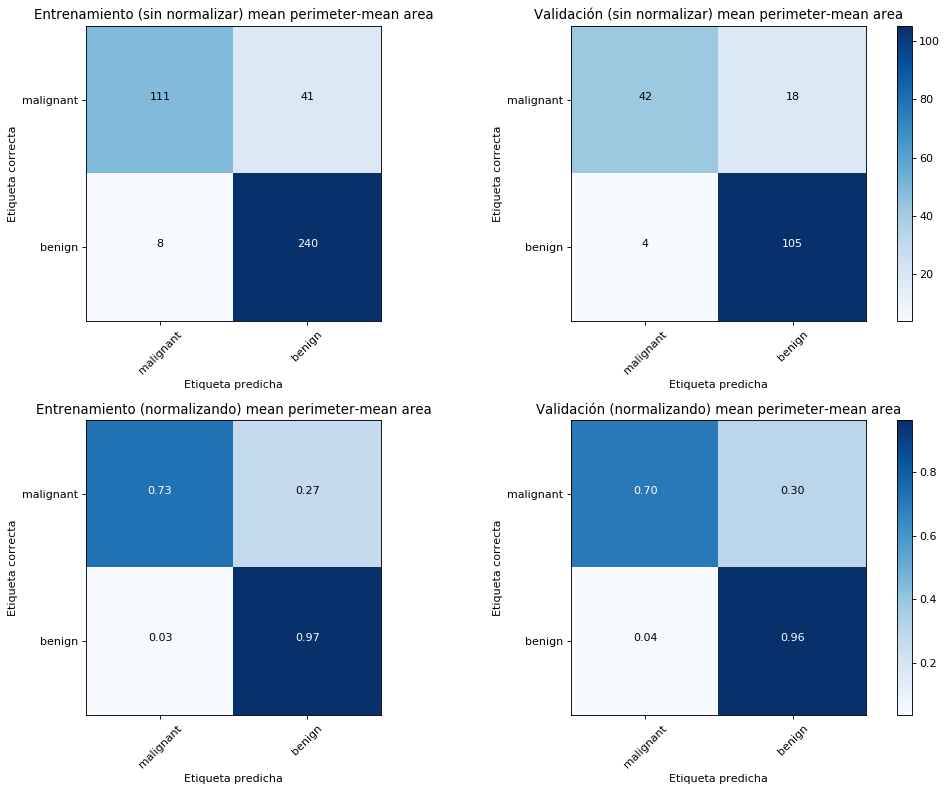

In [85]:
_plot_confusion_matrix(X_train_feature, y_train, X_val_feature, y_val, x_feature, y_feature)

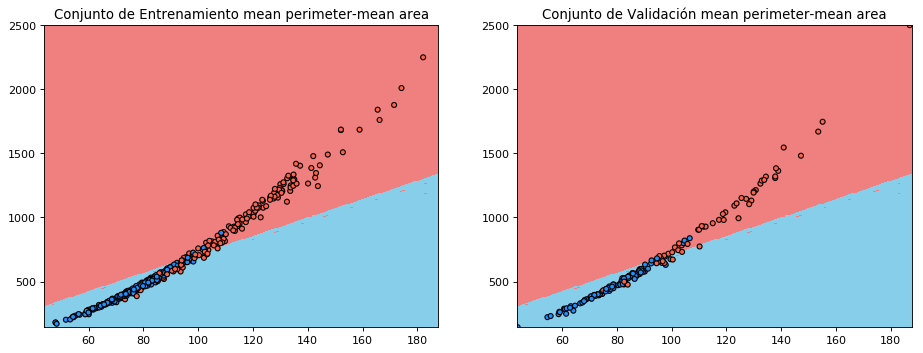

In [86]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model, h=1)

cmap_dots = ListedColormap(['tomato', 'dodgerblue'])
cmap_back = ListedColormap(['lightcoral', 'skyblue'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"Conjunto de Entrenamiento {x_feature}-{y_feature}")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"Conjunto de Validación {x_feature}-{y_feature}")

plt.show()

## Clasificación multiclase

Ahora veremos clasificación multiclase. Muy similar al caso anterior, con la diferencia de que en este caso hay más de dos etiquetas posibles para clasificación. Se utilizará el método `one-vs-all` (o también `one-vs-rest`) para hacer posible la clasificaicón.

Una vez más tenemos que decidir dos features para poder visualizar los modelos.

### Carga de datos

In [58]:
iris_data = load_iris()

# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(150)
shuff_train = shuff_data[:120]
shuff_val = shuff_data[120:]

X_train = iris_data['data'][shuff_train]
X_val = iris_data['data'][shuff_val]

y_train = iris_data['target'][shuff_train]
y_val = iris_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(iris_data['feature_names'])}

print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [59]:
print("Listado de atributos\n====================")
for feature in iris_data['feature_names']:
    print("- %s" % feature)

Listado de atributos
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)


In [60]:
# Seleccionamos dos atributo de los listados en el apartado anterior, uno para el eje x y otro para el eje y
# TODO: Cambiar los atributos y ver como se modifica el resultado
x_feature = 'sepal length (cm)'
y_feature = 'sepal width (cm)'

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

### Regresión logística

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [61]:
penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha =  0.01 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha, multi_class='ovr')
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.80
Exactitud para validación: 0.87


/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luisvargas/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Matriz de confusión

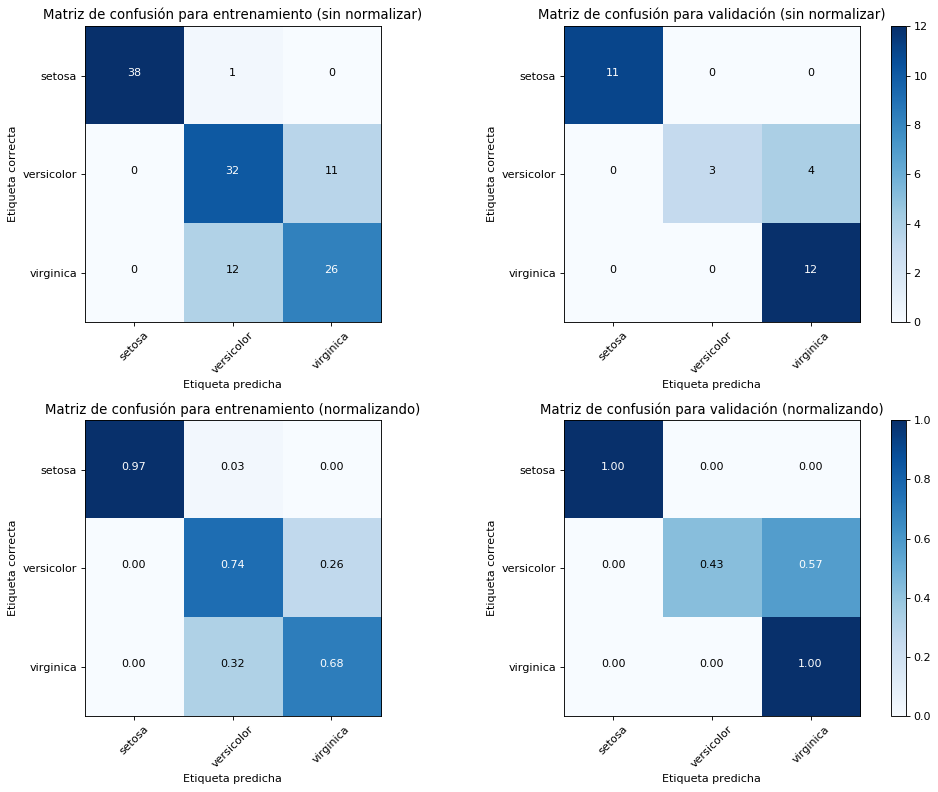

In [62]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

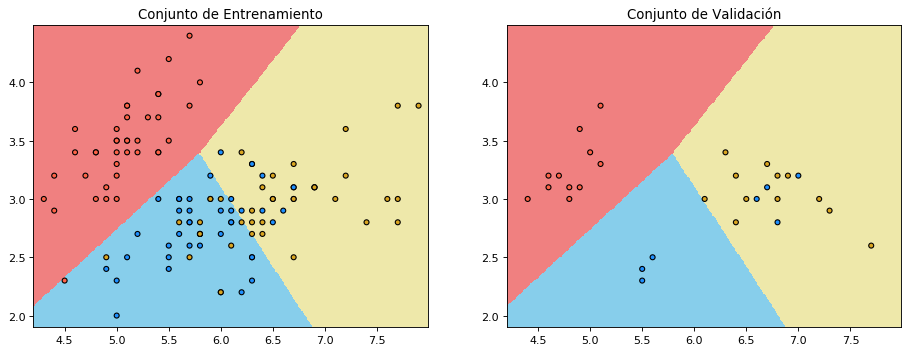

In [63]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()

### Vecinos más cercanos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [64]:
n_neighbors = 2 # Cantidad de vecinos a tener en cuenta
metric = 'euclidean'# Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

Exactitud para entrenamiento: 0.82
Exactitud para validación: 0.77


#### Matriz de confusión

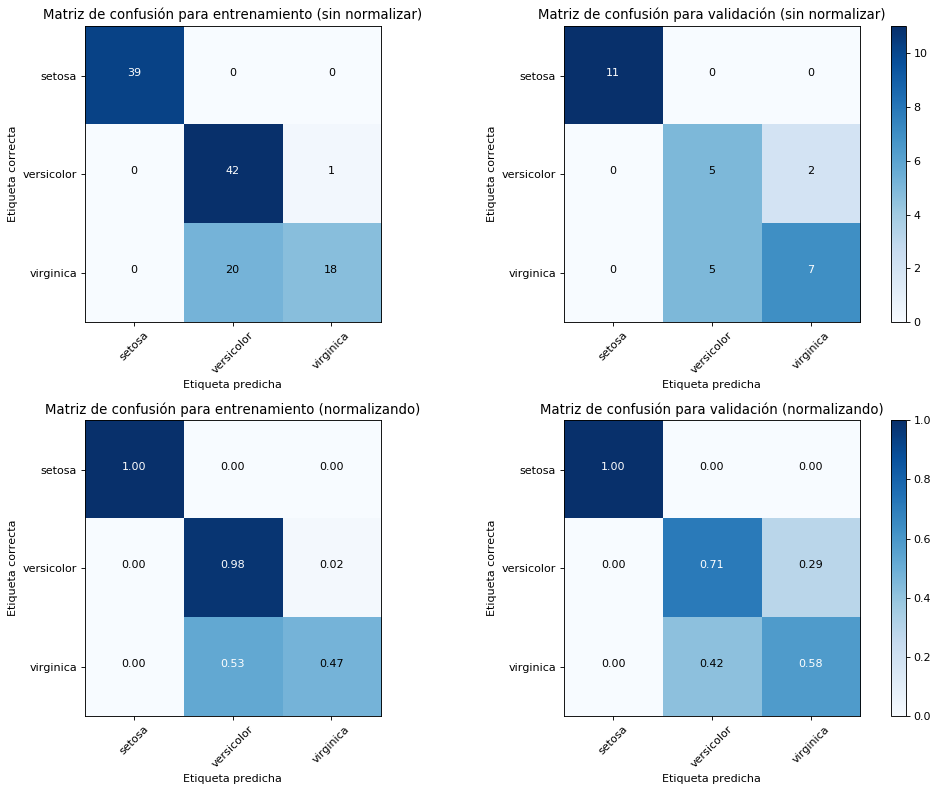

In [65]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

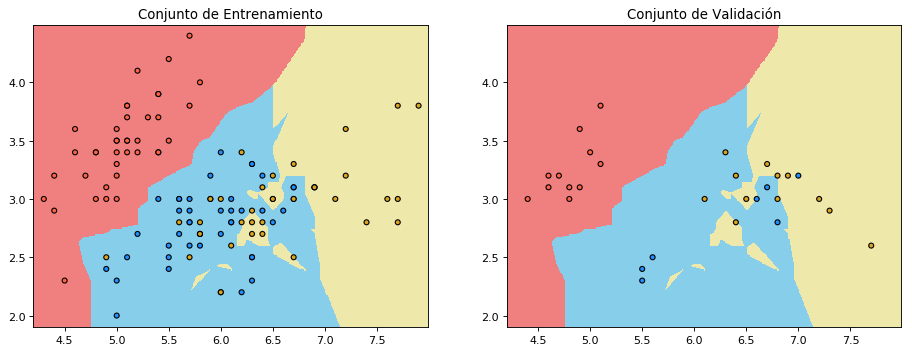

In [66]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()